# ENet -  Real Time Semantic Segmentation

In this notebook, we have reproduced the ENet paper. <br/>
Link to the paper: https://arxiv.org/pdf/1606.02147.pdf <br/>
Link to the repository: https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation


Star and Fork!


**ALL THE CODE IN THIS NOTEBOOK ASSUMES THE USAGE OF THE <span style="color:blue;">CAMVID</span> DATASET**

## Install the dependencies and Import them

In [0]:
!pip install torch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm
from PIL import Image

## Download the dataset (CamVid)

In [0]:
!unzip <link>

## Create the ENet model

In [0]:
class InitialBlock(nn.Module):
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [0]:
class UBNeck(nn.Module):
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # Concat
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag

        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [0]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [0]:
class ENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        return x

## Instantiate the ENet model

In [0]:
enet = ENet(34)

Move the model to cuda if available

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
enet = enet.to(device)

## Define the loader that will load the input and output images

In [0]:
def loader(training_path, segmented_path, batch_size, h=320, w=1000):
    filenames_t = os.listdir(training_path)
    total_files_t = len(filenames_t)
    
    filenames_s = os.listdir(segmented_path)
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    idx = 0
    while(1):
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
            
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            img = plt.imread(training_path + filenames_t[jj])
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            inputs.append(img)
            
            img = Image.open(segmented_path + filenames_s[jj])
            img = np.array(img)
            img = cv2.resize(img, (h, w), cv2.INTER_NEAREST)
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

## Define the class weights

In [0]:
def get_class_weights(num_classes, c=1.02):
    pipe = loader('/content/training/image_2/', '/content/training/semantic/', batch_size=200)
    #pipe = loader('/content/train/', '/content/trainannot/', batch_size='all')
    _, labels = next(pipe)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [0]:
class_weights = get_class_weights(34)

## Define the Hyperparameters

In [0]:
lr = 5e-4
batch_size = 10

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)

print_every = 5
eval_every = 5

## Start the training process

In [0]:
train_losses = []
eval_losses = []

bc_train = 367 // batch_size
bc_eval = 101 // batch_size

pipe = loader('/content/train/', '/content/trainannot/', batch_size)
eval_pipe = loader('/content/val/', '/content/valannot/', batch_size)

epochs = 100
    
for e in range(1, epochs+1):
    
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = enet(X_batch.float())

        loss = criterion(out, mask_batch.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        
    print ()
    train_losses.append(train_loss)
    
    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0
            
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                
                inputs, labels = inputs.to(device), labels.to(device)
                    
                
                out = enet(inputs)
                
                out = out.data.max(1)[1]
                
                eval_loss += (labels.long() - out.long()).sum()
                
            
            print ()
            print ('Loss {:6f}'.format(eval_loss))
            
            eval_losses.append(eval_loss)
        
    if e % print_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict()
        }
        torch.save(checkpoint, '/content/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')

print ('Epoch {}/{}...'.format(e+1, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))

  0%|          | 0/36 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 1/100... Loss 28.979438
--------------- Epoch 2 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 2/100... Loss 29.494250
--------------- Epoch 3 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 3/100... Loss 28.528978
--------------- Epoch 4 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 4/100... Loss 29.328325
--------------- Epoch 5 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 5/100... Loss 29.045529
Model saved!
--------------- Epoch 6 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 6/100... Loss 28.977716
--------------- Epoch 7 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 7/100... Loss 27.080098
--------------- Epoch 8 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 8/100... Loss 27.654813
--------------- Epoch 9 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 9/100... Loss 28.305800
--------------- Epoch 10 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 10/100... Loss 26.860534
Model saved!
--------------- Epoch 11 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 11/100... Loss 26.415380
--------------- Epoch 12 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 12/100... Loss 28.054704
--------------- Epoch 13 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 13/100... Loss 28.186868
--------------- Epoch 14 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 14/100... Loss 28.903453
--------------- Epoch 15 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 15/100... Loss 27.344490
Model saved!
--------------- Epoch 16 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 16/100... Loss 26.123124
--------------- Epoch 17 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 17/100... Loss 27.068494
--------------- Epoch 18 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 18/100... Loss 28.034697
--------------- Epoch 19 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 19/100... Loss 27.565001
--------------- Epoch 20 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 20/100... Loss 27.966862
Model saved!
--------------- Epoch 21 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 21/100... Loss 27.333997
--------------- Epoch 22 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 22/100... Loss 26.716185
--------------- Epoch 23 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 23/100... Loss 25.209534
--------------- Epoch 24 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 24/100... Loss 26.276211
--------------- Epoch 25 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 25/100... Loss 26.260669
Model saved!
--------------- Epoch 26 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 26/100... Loss 25.555487
--------------- Epoch 27 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 27/100... Loss 28.719350
--------------- Epoch 28 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 28/100... Loss 28.494805
--------------- Epoch 29 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 29/100... Loss 28.163527
--------------- Epoch 30 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 30/100... Loss 25.692117
Model saved!
--------------- Epoch 31 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 31/100... Loss 26.097773
--------------- Epoch 32 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 32/100... Loss 25.154811
--------------- Epoch 33 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 33/100... Loss 24.580622
--------------- Epoch 34 ---------------


  0%|          | 0/36 [00:00<?, ?it/s]


Epoch 34/100... Loss 25.557838
--------------- Epoch 35 ---------------


 33%|███▎      | 12/36 [00:19<00:38,  1.62s/it]

## Infer using the trained model

In [0]:
# Load a pretrained model if needed
enet = ENet(12)
state_dict = torch.load('/content/ckpt-enet-1.pth')['state_dict']
enet.load_state_dict(state_dict)

## Use the code to infer on new images

In [0]:
fname = '000054_10.png'
tmg_ = plt.imread('/content/test/' + fname)
tmg_ = cv2.resize(tmg_, (512, 512), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)

enet.to(device)
with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0)

## Load the label image

In [0]:
smg_ = Image.open('/content/testannot/' + fname)
smg_ = cv2.resize(np.array(smg_), (512, 512), cv2.INTER_NEAREST)

## Move the output to cpu and convert it to numpy and see how each class looks


In [0]:
out2 = out1.cpu().detach().numpy()

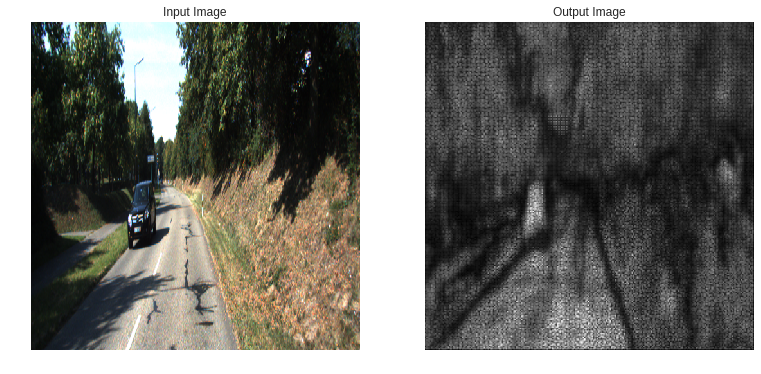

In [0]:
mno = 1 # Should be between 0 - n-1 | where n is the number of classes

figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])
plt.show()

Get the class labels from the output

In [0]:
b_ = out1.data.max(0)[1].cpu().numpy()

Define the function that maps a 2D image with all the class labels to a segmented image with the specified colored maps

In [0]:
def decode_segmap(temp, plot=False):
        Sky = [128, 128, 128]
        Building = [128, 0, 0]
        Pole = [192, 192, 128]
        Road_marking = [255, 69, 0]
        Road = [128, 64, 128]
        Pavement = [60, 40, 222]
        Tree = [128, 128, 0]
        SignSymbol = [192, 128, 128]
        Fence = [64, 64, 128]
        Car = [64, 0, 128]
        Pedestrian = [64, 64, 0]
        Bicyclist = [0, 128, 192]

        label_colours = np.array([Sky, Building, Pole, Road_marking, Road, 
                                  Pavement, Tree, SignSymbol, Fence, Car, 
                                  Pedestrian, Bicyclist]).astype(np.uint8)
        r = np.zeros_like(temp).astype(np.uint8)
        g = np.zeros_like(temp).astype(np.uint8)
        b = np.zeros_like(temp).astype(np.uint8)
        for l in range(0, 12):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3)).astype(np.uint8)
        rgb[:, :, 0] = b
        rgb[:, :, 1] = g
        rgb[:, :, 2] = r
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb
        

Decode the images

In [0]:
true_seg = decode_segmap(smg_)
pred_seg = decode_segmap(b_)

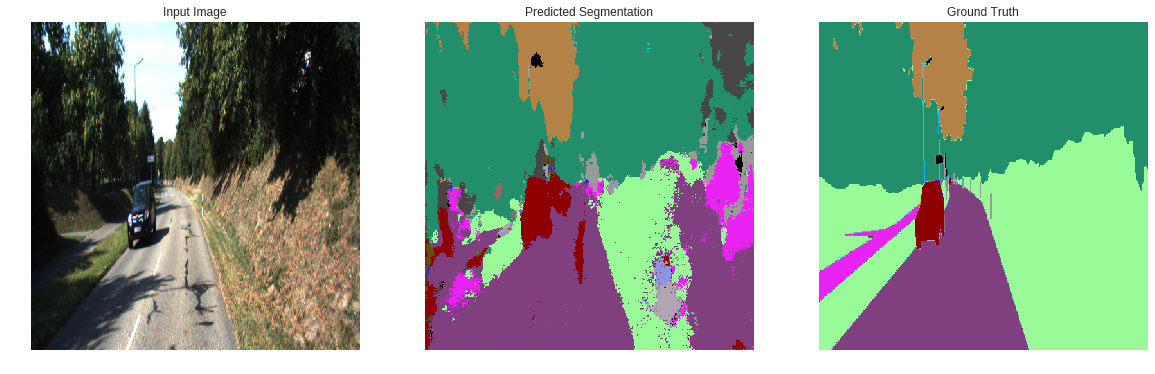

In [0]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(pred_seg)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(true_seg)
plt.show()

## Save the model checkpoint

In [0]:
# Save the parameters
checkpoint = {
    'epochs' : e,
    'state_dict' : enet.state_dict()
}
torch.save(checkpoint, 'ckpt-enet-1.pth')

## Save the entire model

In [0]:
# Save the model
torch.save(enet, '/content/model.pt')